In [1]:
# Test code for sympy

from sympy import symbols, simplify

# Define the symbol
x = symbols('x')

# Define the equation
equation = 4.246*x + 2.3*(0.149 - x)**2 + 11.949

# Simplify the equation
simplified_equation = simplify(equation)
print(simplified_equation)

equation = 0.65*(1-0.072*x)**3+0.349
print(simplify(equation))

2.3*x**2 + 3.5606*x + 12.0000623
0.349 - 0.65*(0.072*x - 1)**3


In [2]:
# Load symbolicregression model

import torch
import numpy as np
import sympy as sp
import os, sys
import symbolicregression
import sympytorch
import requests
from IPython.display import display

model_path = "ckpt/model.pt" 
try:
    if not os.path.isfile(model_path): 
        print("Downloading model...")
        url = "https://dl.fbaipublicfiles.com/symbolicregression/model1.pt"
        r = requests.get(url, allow_redirects=True)
        open(model_path, 'wb').write(r.content)
    if not torch.cuda.is_available():
        model = torch.load(model_path, map_location=torch.device('cpu'))
    else:
        model = torch.load(model_path)
        model = model.cuda()
    print(model.device)
    print("Model successfully loaded!")

except Exception as e:
    print("ERROR: model not loaded! path was: {}".format(model_path))
    print(e)    
    
est = symbolicregression.model.SymbolicTransformerRegressor(
                        model=model,
                        max_input_points=10000,
                        n_trees_to_refine=100,
                        rescale=True
                        )
##Example of data

x = np.random.randn(10000,1)
print(x.shape)
y = np.cos(2*np.pi*x)+x**2
print(y.shape)

est.fit(x,y)
replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)
display(sp.parse_expr(model_str))

/home/mcwave/anaconda3/envs/symbolic/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


cuda:0
Model successfully loaded!
(10000, 1)
(10000, 1)


(1.2467509171168861e-6 - 0.00018361598935883966*x_0)*(17.896929825427563 - 5.2761586181253834/(0.012470406689508922 + 8.123412272697365e-11/(7000.480493503186*(-x_0 - 0.00047080124007207385*cos(0.0020046111823134584*x_0 - 1.36112919073066e-5) - 0.86504980835989261)**2 - 0.5800665197625626)))*(13.440729194298904*x_0 + 0.091262454848705538) + 0.9999999935046022*cos(6.2831853045368993*x_0 - 1.6787817069699538e-8) + 4.610255651930134e-5

4.6*x - 4.96


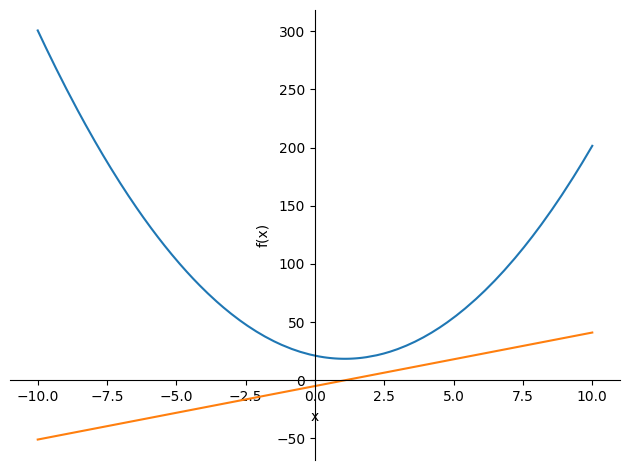

In [3]:
from sympy import Symbol
from sympy.plotting import plot

x = Symbol('x')
y = 4.24*x + 2.3*(x-2)**2 + 11.95
yprime = y.diff(x)
print(yprime)

p1 = plot(y, yprime, (x, -10, 10), show=True)

In [4]:
import numpy as np
from sympy import Symbol, lambdify
from sympy.plotting import plot

DELTA = 0.001
RANGE_MIN = -5.0
RANGE_MAX = 5.0

x = Symbol('x')
y = 4.24*x + 2.3*(x-2)**2 + 11.95

xs = np.arange(RANGE_MIN, RANGE_MAX, DELTA) 
f = lambdify(x, y, "numpy") 
ys = f(xs-DELTA/2) 

ds = (ys[1:] - ys[0:-1]) / DELTA

est.fit(np.reshape(xs[0:-1], (len(xs)-1,1)),
        np.reshape(ds, (len(ds), 1)))
replace_ops = {"add": "+", "mul": "*", "sub": "-", "pow": "**", "inv": "1/"}
model_str = est.retrieve_tree(with_infos=True)["relabed_predicted_tree"].infix()
for op,replace_op in replace_ops.items():
    model_str = model_str.replace(op,replace_op)
display(sp.parse_expr(model_str))

4.6000000000016062*x_0 - 4.9600000000013106

In [5]:
import numpy as np
from sympy import Symbol, lambdify
from sympy.plotting import plot

DELTA = 0.001
RANGE_MIN = 0.0
RANGE_MAX = 5.0

x = Symbol('x')
t = Symbol('t')
y = x*x + 0.1*t*t

xs = np.arange(RANGE_MIN, RANGE_MAX, DELTA) 
ts = np.arange(RANGE_MIN, RANGE_MAX, DELTA) 
f = lambdify((x, t), y, "numpy") 
ys = f(xs, 2)
#print(xs)
print(ys)

[ 0.4       0.400001  0.400004 ... 25.370009 25.380004 25.390001]


In [6]:
import numpy as np
from sympy import Symbol, lambdify
from sympy.plotting import plot

class PartialDerivativeCalculator:
    
    # Example: Vibrating strings problem
    # y = f(x, t), where x is the horizontal position, and t is time
    # self.data is a 2D array that records the y value for each x and t,
    #   with first dim being x and second dim being t
    # self.axes_values contains the values of x and t
    def __init__(self, shape):
        assert len(shape) <= 3
        self.shape = shape
        self.data = np.zeros(shape)
        self.axes_values = [None]*len(shape)
        for i in range(len(shape)):
            self.axes_values[i] = np.zeros(shape[i])
            
    def setAxisValues(self, i, axis_values):
        self.axes_values[i] = axis_values
        
    def setData(self, data):
        self.data = data
        
    def updateRow2D(self, i, values):
        self.data[i] = values
        
    def updateRow3D(self, i1, i2, values):
        self.data[i1,i2,:] = values
    
    def updateRow4D(self, i1, i2, i3, values):
        self.data[i1,i2,i3,:] = values
        
    def partialDerivative(self, iDim, padding=True):
        if iDim == 0:
            axis_delta = self.axes_values[iDim][1:] - self.axes_values[iDim][0:-1]
            value_delta = self.data[1:] - self.data[0:-1]
            axis_delta = np.broadcast_to(axis_delta[:, np.newaxis, np.newaxis], value_delta.shape)
            derivative = value_delta / axis_delta
            if padding:
                derivative = np.concatenate([derivative, [derivative[-1]]], axis=0)
            return derivative
        elif iDim == 1:
            axis_delta = self.axes_values[iDim][1:] - self.axes_values[iDim][0:-1]
            value_delta = self.data[:,1:,:] - self.data[:,0:-1,:]
            axis_delta = np.broadcast_to(axis_delta[np.newaxis, :, np.newaxis], value_delta.shape)
            derivative = value_delta / axis_delta
            if padding:
                derivative = np.concatenate([derivative, derivative[:,-1:,:]], axis=1)
            return derivative
        elif iDim == 2:
            axis_delta = self.axes_values[iDim][1:] - self.axes_values[iDim][0:-1]
            value_delta = self.data[:,:,1:] - self.data[:,:,0:-1]
            axis_delta = np.broadcast_to(axis_delta[np.newaxis, np.newaxis, :], value_delta.shape)
            derivative = value_delta / axis_delta
            if padding:
                derivative = np.concatenate([derivative, derivative[:,:,-1:]], axis=2)
            return derivative
        return None
    
if __name__ == '__main__':
    # Test 1: Partial derivative along axis 0
    pdc = PartialDerivativeCalculator((3,4,5))
    pdc.setAxisValues(0, np.array([0, 0.1, 0.3]))
    pdc.setAxisValues(1, np.array([0, 0.2, 0.4, 0.6]))
    pdc.setAxisValues(2, np.array(list(range(5))))
    pdc.updateRow3D(1,2,np.ones(5))
    expected = np.array(
        [[[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [10., 10., 10., 10., 10.],
          [ 0.,  0.,  0.,  0.,  0.]],
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [-5., -5., -5., -5., -5.],
          [ 0.,  0.,  0.,  0.,  0.]],
         [[ 0.,  0.,  0.,  0.,  0.],
          [ 0.,  0.,  0.,  0.,  0.],
          [-5., -5., -5., -5., -5.],
          [ 0.,  0.,  0.,  0.,  0.]]])
    print("np.allclose(expected,pdc.partialDerivative(0))", 
          np.allclose(expected,pdc.partialDerivative(0)))
    assert np.allclose(expected,pdc.partialDerivative(0)), "pdc.partialDerivative(0) not as expected"
    # Test 2: Partial derivative along axis 1
    pdc = PartialDerivativeCalculator((3,4,5))
    pdc.setAxisValues(0, np.array([0, 0.1, 0.3]))
    pdc.setAxisValues(1, np.array([0, 0.3, 0.5, 0.6]))
    pdc.setAxisValues(2, np.array(list(range(5))))
    pdc.updateRow3D(1,2,np.ones(5))
    expected = np.array(
      [[[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  5.,   5.,   5.,   5.,   5.],
        [-10., -10., -10., -10., -10.],
        [-10., -10., -10., -10., -10.]],

       [[  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.],
        [  0.,   0.,   0.,   0.,   0.]]])
    print("np.allclose(expected,pdc.partialDerivative(1))", 
          np.allclose(expected,pdc.partialDerivative(1)))
    assert np.allclose(expected,pdc.partialDerivative(1)), "pdc.partialDerivative(1) not as expected"
    # Test 3: Partial derivative along axis 2
    pdc = PartialDerivativeCalculator((3,4,5))
    pdc.setAxisValues(0, np.array([0, 0.1, 0.3]))
    pdc.setAxisValues(1, np.array([0, 0.3, 0.5, 0.6]))
    pdc.setAxisValues(2, 0.1*np.array(list(range(5))))
    pdc.updateRow3D(2,2,np.asarray(range(5)))
    expected = np.array(
      [[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [10., 10., 10., 10., 10.],
        [ 0.,  0.,  0.,  0.,  0.]]])
    print("np.allclose(expected,pdc.partialDerivative(2))", 
          np.allclose(expected,pdc.partialDerivative(2)))
    assert np.allclose(expected,pdc.partialDerivative(2)), "pdc.partialDerivative(2) not as expected"
    

np.allclose(expected,pdc.partialDerivative(0)) True
np.allclose(expected,pdc.partialDerivative(1)) True
np.allclose(expected,pdc.partialDerivative(2)) True


In [7]:
import numpy as np
data = np.zeros((3,4,5))
#data[1,2,:] = np.ones(5)
data[2,2,:] = np.asarray(range(5))
print(data)

delta = data[:,:,1:] - data[:,:,0:-1]
print("delta", delta)

x = np.array([0.1, 0.1, 0.1, 0.1])
x = np.broadcast_to(x[np.newaxis, np.newaxis, :], delta.shape)
print("x", x)

derivative = delta/x
print("derivative", derivative)
print("derivative[:,-1,:]", derivative[:,:,-1:])
np.concatenate([derivative, derivative[:,:,-1:]], axis=2)

[[[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]]

 [[0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0.]
  [0. 1. 2. 3. 4.]
  [0. 0. 0. 0. 0.]]]
delta [[[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [0. 0. 0. 0.]]

 [[0. 0. 0. 0.]
  [0. 0. 0. 0.]
  [1. 1. 1. 1.]
  [0. 0. 0. 0.]]]
x [[[0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]]

 [[0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]]

 [[0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]
  [0.1 0.1 0.1 0.1]]]
derivative [[[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]]

 [[ 0.  0.  0.  0.]
  [ 0.  0.  0.  0.]
  [10. 10. 10. 10.]
  [ 0.  0.  0.  0.]]]
derivative[:,-1,:] [[[ 0.]
  [ 0.]
  [ 0.]
  [ 0.]]

 [[ 

array([[[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.]],

       [[ 0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.],
        [10., 10., 10., 10., 10.],
        [ 0.,  0.,  0.,  0.,  0.]]])